## Import

In [1]:
import random
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [3]:
CFG = {
    'TRAIN_WINDOW_SIZE':90, # 90일치로 학습
    'PREDICT_SIZE':21, # 21일치 예측
    'EPOCHS':50,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':4096,
    'SEED':42
}

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

### 데이터 불러오기

In [5]:
train_data = pd.read_csv('./train.csv').drop(columns=['ID', '제품'])

In [9]:
train_data

,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,B002-C001-0003,B002-C002-0008,B002-C003-0042,B002-03799,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15886,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,0,0,...,0,0,0,3,0,2,4,1,1,3
15887,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15888,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [7]:
numeric_cols = train_data.columns[4:]
numeric_cols

Index(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05',
       '2022-01-06', '2022-01-07', '2022-01-08', '2022-01-09', '2022-01-10',
       ...
       '2023-03-26', '2023-03-27', '2023-03-28', '2023-03-29', '2023-03-30',
       '2023-03-31', '2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04'],
      dtype='object', length=459)

In [8]:
train_data[numeric_cols]

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15886,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,2,4,1,1,3
15887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15888,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [10]:
sales_data = pd.read_csv('./sales.csv').drop(columns=['ID', '제품'])

In [11]:
sales_data

,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,0,...,0,0,0,22400,67200,44800,0,0,44800,0
2,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,B002-C001-0003,B002-C002-0008,B002-C003-0042,B002-03799,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15886,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,0,0,...,0,0,0,60690,0,40460,80920,20230,20230,60690
15887,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15888,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,27300


In [26]:
sales_data[numeric_cols]

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,22400,67200,44800,0,0,44800,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15886,0,0,0,0,0,0,0,0,0,0,...,0,0,0,60690,0,40460,80920,20230,20230,60690
15887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15888,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,27300


In [13]:
sales_per_data = sales_data[numeric_cols] / train_data[numeric_cols]

In [14]:
sales_per_data

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,22400.0,22400.0,22400.0,NaN,NaN,22400.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,20230.0,NaN,20230.0,20230.0,20230.0,20230.0,20230.0
15887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13650.0


In [23]:
sales_per_data = sales_per_data.fillna(0)

In [24]:
sales_per_data

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,22400.0,22400.0,22400.0,0.0,0.0,22400.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,20230.0,0.0,20230.0,20230.0,20230.0,20230.0,20230.0
15887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13650.0


In [28]:
train_data[numeric_cols].to_csv('./train_data_key.csv', index=False)

In [21]:
row_num = 51  # 예시로 세 번째 행을 선택
unique_values = sales_per_data.iloc[row_num].dropna().nunique()

print(f"Number of unique values in row {row_num} (excluding NaN): {unique_values}")

Number of unique values in row 51 (excluding NaN): 11


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = train_data[numeric_cols].corrwith(sales_data[numeric_cols])

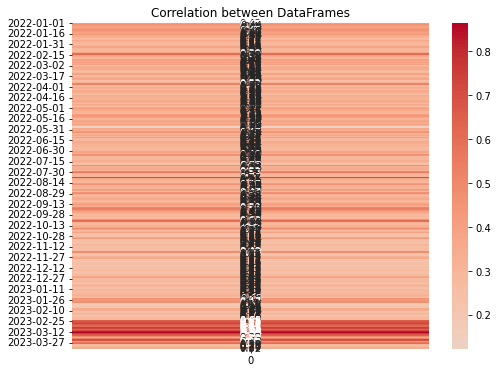

In [30]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation between DataFrames")
plt.show()

### 데이터 전처리

In [6]:
# 숫자형 변수들의 min-max scaling을 수행하는 코드입니다.
numeric_cols = train_data.columns[4:]
# 칵 column의 min 및 max 계산
min_values = train_data[numeric_cols].min(axis=1)
max_values = train_data[numeric_cols].max(axis=1)
# 각 행의 범위(max-min)를 계산하고, 범위가 0인 경우 1로 대체
ranges = max_values - min_values
ranges[ranges == 0] = 1
# min-max scaling 수행
train_data[numeric_cols] = (train_data[numeric_cols].subtract(min_values, axis=0)).div(ranges, axis=0)
# max와 min 값을 dictionary 형태로 저장
scale_min_dict = min_values.to_dict()
scale_max_dict = max_values.to_dict()

In [7]:
# Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ['대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    label_encoder.fit(train_data[col])
    train_data[col] = label_encoder.transform(train_data[col])

In [8]:
def make_train_data(data, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    '''
    학습 기간 블럭, 예측 기간 블럭의 세트로 데이터를 생성
    data : 일별 판매량
    train_size : 학습에 활용할 기간
    predict_size : 추론할 기간
    '''
    num_rows = len(data)
    window_size = train_size + predict_size
    
    input_data = np.empty((num_rows * (len(data.columns) - window_size + 1), train_size, len(data.iloc[0, :4]) + 1))
    target_data = np.empty((num_rows * (len(data.columns) - window_size + 1), predict_size))
    
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :4])
        sales_data = np.array(data.iloc[i, 4:])
        
        for j in range(len(sales_data) - window_size + 1):
            window = sales_data[j : j + window_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            input_data[i * (len(data.columns) - window_size + 1) + j] = temp_data
            target_data[i * (len(data.columns) - window_size + 1) + j] = window[train_size:]
    
    return input_data, target_data

In [9]:
def make_predict_data(data, train_size=CFG['TRAIN_WINDOW_SIZE']):
    '''
    평가 데이터(Test Dataset)를 추론하기 위한 Input 데이터를 생성
    data : 일별 판매량
    train_size : 추론을 위해 필요한 일별 판매량 기간 (= 학습에 활용할 기간)
    '''
    num_rows = len(data)
    
    input_data = np.empty((num_rows, train_size, len(data.iloc[0, :4]) + 1))
    
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :4])
        sales_data = np.array(data.iloc[i, -train_size:])
        
        window = sales_data[-train_size : ]
        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i] = temp_data
    
    return input_data

In [10]:
train_input, train_target = make_train_data(train_data)
test_input = make_predict_data(train_data)

100%|████████████████████████████████████| 15890/15890 [00:42<00:00, 376.16it/s]


In [11]:
# Train / Validation Split
data_len = len(train_input)
val_input = train_input[-int(data_len*0.2):]
val_target = train_target[-int(data_len*0.2):]
train_input = train_input[:-int(data_len*0.2)]
train_target = train_target[:-int(data_len*0.2)]

In [12]:
train_input.shape, train_target.shape, val_input.shape, val_target.shape, test_input.shape

((4487336, 90, 5),
 (4487336, 21),
 (1121834, 90, 5),
 (1121834, 21),
 (15890, 90, 5))

### Custom Dataset

In [13]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])
    
    def __len__(self):
        return len(self.X)

In [14]:
train_dataset = CustomDataset(train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_input, val_target)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

### 모델 선언

In [19]:
class BaseModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=512, output_size=CFG['PREDICT_SIZE']):
        super(BaseModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_size//2, output_size)
        )
            
        self.actv = nn.ReLU()
    
    def forward(self, x):
        # x shape: (B, TRAIN_WINDOW_SIZE, 5)
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)
        
        # LSTM layer
        lstm_out, hidden = self.lstm(x, hidden)
        
        # Only use the last output sequence
        last_output = lstm_out[:, -1, :]
        
        # Fully connected layer
        output = self.actv(self.fc(last_output))
        
        return output.squeeze(1)
    
    def init_hidden(self, batch_size, device):
        # Initialize hidden state and cell state
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))

### 모델 학습

In [20]:
def train(model, optimizer, train_loader, val_loader, device):
    model.to(device)
    criterion = nn.MSELoss().to(device)
    best_loss = 9999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        train_mae = []
        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)
            
            optimizer.zero_grad()
            
            output = model(X)
            loss = criterion(output, Y)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        val_loss = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]')
        
        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
            print('Model Saved')
    return best_model

In [21]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    
    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.to(device)
            Y = Y.to(device)
            
            output = model(X)
            loss = criterion(output, Y)
            
            val_loss.append(loss.item())
    return np.mean(val_loss)

## Run !!

In [22]:
model = BaseModel()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
infer_model = train(model, optimizer, train_loader, val_loader, device)

100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 32.01it/s]


Epoch : [1] Train Loss : [0.02292] Val Loss : [0.03024]
Model Saved


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.55it/s]


Epoch : [2] Train Loss : [0.01852] Val Loss : [0.02049]
Model Saved


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.66it/s]


Epoch : [3] Train Loss : [0.01823] Val Loss : [0.02133]


100%|███████████████████████████████████████| 1096/1096 [00:35<00:00, 31.20it/s]


Epoch : [4] Train Loss : [0.01802] Val Loss : [0.01832]
Model Saved


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.40it/s]


Epoch : [5] Train Loss : [0.01788] Val Loss : [0.01796]
Model Saved


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 32.01it/s]


Epoch : [6] Train Loss : [0.01776] Val Loss : [0.01816]


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.60it/s]


Epoch : [7] Train Loss : [0.01770] Val Loss : [0.01917]


100%|███████████████████████████████████████| 1096/1096 [00:35<00:00, 31.10it/s]


Epoch : [8] Train Loss : [0.01764] Val Loss : [0.01737]
Model Saved


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.95it/s]


Epoch : [9] Train Loss : [0.01757] Val Loss : [0.01734]
Model Saved


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.88it/s]


Epoch : [10] Train Loss : [0.01752] Val Loss : [0.01735]


100%|███████████████████████████████████████| 1096/1096 [00:35<00:00, 31.07it/s]


Epoch : [11] Train Loss : [0.01750] Val Loss : [0.01721]
Model Saved


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.46it/s]


Epoch : [12] Train Loss : [0.01746] Val Loss : [0.01750]


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.44it/s]


Epoch : [13] Train Loss : [0.01743] Val Loss : [0.01772]


100%|███████████████████████████████████████| 1096/1096 [00:35<00:00, 31.14it/s]


Epoch : [14] Train Loss : [0.01741] Val Loss : [0.01823]


100%|███████████████████████████████████████| 1096/1096 [00:35<00:00, 31.12it/s]


Epoch : [15] Train Loss : [0.01738] Val Loss : [0.01715]
Model Saved


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.67it/s]


Epoch : [16] Train Loss : [0.01734] Val Loss : [0.01724]


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.88it/s]


Epoch : [17] Train Loss : [0.01732] Val Loss : [0.01780]


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.69it/s]


Epoch : [18] Train Loss : [0.01730] Val Loss : [0.01771]


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.48it/s]


Epoch : [19] Train Loss : [0.01727] Val Loss : [0.01712]
Model Saved


100%|███████████████████████████████████████| 1096/1096 [00:35<00:00, 31.11it/s]


Epoch : [20] Train Loss : [0.01724] Val Loss : [0.01770]


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.60it/s]


Epoch : [21] Train Loss : [0.01722] Val Loss : [0.01707]
Model Saved


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.58it/s]


Epoch : [22] Train Loss : [0.01719] Val Loss : [0.01708]


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.47it/s]


Epoch : [23] Train Loss : [0.01717] Val Loss : [0.01733]


100%|███████████████████████████████████████| 1096/1096 [00:35<00:00, 31.11it/s]


Epoch : [24] Train Loss : [0.01714] Val Loss : [0.01697]
Model Saved


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.53it/s]


Epoch : [25] Train Loss : [0.01710] Val Loss : [0.01714]


100%|███████████████████████████████████████| 1096/1096 [00:35<00:00, 31.22it/s]


Epoch : [26] Train Loss : [0.01708] Val Loss : [0.01719]


100%|███████████████████████████████████████| 1096/1096 [00:35<00:00, 31.18it/s]


Epoch : [27] Train Loss : [0.01705] Val Loss : [0.01695]
Model Saved


100%|███████████████████████████████████████| 1096/1096 [00:35<00:00, 31.02it/s]


Epoch : [28] Train Loss : [0.01703] Val Loss : [0.01697]


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.56it/s]


Epoch : [29] Train Loss : [0.01701] Val Loss : [0.01693]
Model Saved


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.40it/s]


Epoch : [30] Train Loss : [0.01699] Val Loss : [0.01706]


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.34it/s]


Epoch : [31] Train Loss : [0.01697] Val Loss : [0.01700]


100%|███████████████████████████████████████| 1096/1096 [00:35<00:00, 31.27it/s]


Epoch : [32] Train Loss : [0.01696] Val Loss : [0.01697]


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.86it/s]


Epoch : [33] Train Loss : [0.01695] Val Loss : [0.01746]


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.63it/s]


Epoch : [34] Train Loss : [0.01693] Val Loss : [0.01713]


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.40it/s]


Epoch : [35] Train Loss : [0.01692] Val Loss : [0.01740]


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.42it/s]


Epoch : [36] Train Loss : [0.01690] Val Loss : [0.01688]
Model Saved


100%|███████████████████████████████████████| 1096/1096 [00:35<00:00, 31.27it/s]


Epoch : [37] Train Loss : [0.01689] Val Loss : [0.01704]


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.42it/s]


Epoch : [38] Train Loss : [0.01688] Val Loss : [0.01686]
Model Saved


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.50it/s]


Epoch : [39] Train Loss : [0.01687] Val Loss : [0.01692]


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.54it/s]


Epoch : [40] Train Loss : [0.01685] Val Loss : [0.01695]


100%|███████████████████████████████████████| 1096/1096 [00:35<00:00, 31.24it/s]


Epoch : [41] Train Loss : [0.01683] Val Loss : [0.01674]
Model Saved


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.86it/s]


Epoch : [42] Train Loss : [0.01683] Val Loss : [0.01691]


100%|███████████████████████████████████████| 1096/1096 [00:33<00:00, 32.31it/s]


Epoch : [43] Train Loss : [0.01681] Val Loss : [0.01727]


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 32.14it/s]


Epoch : [44] Train Loss : [0.01680] Val Loss : [0.01722]


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.66it/s]


Epoch : [45] Train Loss : [0.01678] Val Loss : [0.01696]


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.34it/s]


Epoch : [46] Train Loss : [0.01677] Val Loss : [0.01699]


100%|███████████████████████████████████████| 1096/1096 [00:34<00:00, 31.64it/s]


Epoch : [47] Train Loss : [0.01676] Val Loss : [0.01686]


100%|███████████████████████████████████████| 1096/1096 [00:35<00:00, 31.19it/s]


Epoch : [48] Train Loss : [0.01675] Val Loss : [0.01753]


100%|███████████████████████████████████████| 1096/1096 [00:26<00:00, 41.66it/s]


Epoch : [49] Train Loss : [0.01674] Val Loss : [0.01680]


100%|███████████████████████████████████████| 1096/1096 [00:26<00:00, 41.91it/s]

Epoch : [50] Train Loss : [0.01672] Val Loss : [0.01696]


## 모델 추론

In [23]:
test_dataset = CustomDataset(test_input, None)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [24]:
def inference(model, test_loader, device):
    predictions = []
    
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(device)
            
            output = model(X)
            
            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()
            
            predictions.extend(output)
    
    return np.array(predictions)

In [25]:
pred = inference(infer_model, test_loader, device)

100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 61.21it/s]


In [26]:
# 추론 결과를 inverse scaling
for idx in range(len(pred)):
    pred[idx, :] = pred[idx, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]
    
# 결과 후처리
pred = np.round(pred, 0).astype(int)

In [27]:
pred.shape

(15890, 21)

## Submission

In [28]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
submit.iloc[:,1:] = pred
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
submit.to_csv('./lstm_seed42_batch1024_epochs50.csv', index=False)